In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
datadir="/cellar/users/snwright/Data/RareCommon/"

In [255]:
pilot = pd.read_csv(datadir+"pilot2_netcoloc_results_combined.txt", sep="\t")
overlap = pd.read_csv(datadir + "pilot_overlap_results_matrix4.txt", sep="\t")

In [256]:
rare_counts = overlap.loc[:, ("TraitR", "Rare")].drop_duplicates(ignore_index=True).set_index("TraitR").Rare.to_dict()
common_counts = overlap.loc[:, ("TraitC", "Common")].drop_duplicates(ignore_index=True).set_index("TraitC").Common.to_dict()

In [258]:
overlap

,TraitC,TraitR,Common,Rare,Overlap,Overlap_p
0,30630,30630,1216,29,17,5.971442e-15
1,30630,30640,1216,19,6,1.168089e-04
2,30630,30830,1216,18,5,6.792864e-04
3,30630,30840,1216,23,1,4.430368e-01
4,30630,30880,1216,24,0,7.989234e-01
...,...,...,...,...,...,...
436,XVII_MALFORMAT_ABNORMAL,C3_PRIMARY_LYMPHOID_HEMATOPOIETIC,0,10,0,0.000000e+00
437,XVII_MALFORMAT_ABNORMAL,C92,0,8,0,0.000000e+00
438,XVII_MALFORMAT_ABNORMAL,D46,0,8,0,0.000000e+00
439,XVII_MALFORMAT_ABNORMAL,D47,0,8,0,0.000000e+00


In [260]:
traits = {"30630":"Apolipoprotein A", "30640":"Apolipoprotein B", "23110":"Impedance of Arm", "30830":"SHBG", "30840":"Total bilirubin", 
            "30050": "Mean corpuscular haemoglobin", "30140":"Neutrophil count", "30250": "Reticulocyte count", "30880":"Urate",
         "20015":"Sitting Height", "20151":"Forced Vital Capacity", "23098":"Weight",
        "2453": "Cancer Diagnosis", "3063":"Forced Expiratory Volume", "30680":"Calcium", "5133":"6mm strong meridian (R)"}
int_traits = {}
for t in traits:
    int_traits[int(t)] = traits[t]
traits = {**traits,**int_traits,  "C3_PRIMARY_LYMPHOID_HEMATOPOIETIC":"ICD10:Primary lymphoid/haem. malignant neoplasms", "C92":"ICD10:Myeloid Leukemia", 
          "D46":"ICD10:Myelodysplastic Syndromes", "D47":"ICD10: Other lymphoid/haem. neoplasms", 
          "XVII_MALFORMAT_ABNORMAL":"ICD10:Congenital Abnormalities" }
missing_traits = ["C92","D46", "XVII_MALFORMAT_ABNORMAL"]
missing_df = pd.concat([pd.DataFrame({"Trait_Common": pilot.Trait_Common.unique(), "Trait_Rare":miss}) for miss in missing_traits])
pilot = pd.concat([pilot, missing_df])

In [261]:
pilot = pilot.replace(traits)
overlap = overlap.replace(traits)
#overlap = overlap.set_index("TraitC")
#overlap.index.name=None
rare_count_dict = {traits[t]:rare_counts[t] for t in rare_counts}
common_count_dict = {traits[t]:common_counts[t] for t in common_counts}
rare_counts = {**rare_counts, **rare_count_dict}
common_counts = {**common_counts, **common_count_dict}

In [262]:
pilot = pilot[pilot["Trait_Common"] != "Trait_Common"]
pilot["Mean_NPS"] = pilot["Mean_NPS"].astype(float)
pilot["p_NPS"] = pilot["p_NPS"].astype(float)
pilot["p_Size"] = pilot["p_Size"].astype(float)

In [263]:
pilot["OE"] = pilot["Size"].astype(float) / pilot["Null_Size"].astype(float)

In [264]:
pilot.Trait_Common.unique()

array(['Apolipoprotein A', 'Apolipoprotein B', 'SHBG', 'Total bilirubin',
       'Urate', 'Impedance of Arm', 'Mean corpuscular haemoglobin',
       'Neutrophil count', 'Reticulocyte count', 'Sitting Height',
       'Forced Vital Capacity', 'Weight', 'Cancer Diagnosis',
       'Forced Expiratory Volume', 'Calcium', '6mm strong meridian (R)',
       'ICD10:Primary lymphoid/haem. malignant neoplasms',
       'ICD10:Myeloid Leukemia', 'ICD10:Myelodysplastic Syndromes',
       'ICD10: Other lymphoid/haem. neoplasms',
       'ICD10:Congenital Abnormalities'], dtype=object)

In [273]:
pilot["anno"] = pilot.p_Size.apply(lambda x: "***" if x < 0.0000001 else "**" if x < 0.00001 else "*" if x < 0.001 else "")
overlap["anno"] = overlap.Overlap_p.apply(lambda x: "***" if x < 0.0000001 else "**" if x < 0.00001 else "*" if x < 0.001 else "")

In [266]:
pilot.anno.value_counts()

       293
***     92
*       25
**      21
Name: anno, dtype: int64

In [267]:
p_size = pilot.pivot(index="Trait_Common", columns="Trait_Rare", values="p_Size")
ratio = pilot.pivot(index="Trait_Common", columns="Trait_Rare", values="OE")
anno = pilot.pivot(index="Trait_Common", columns="Trait_Rare", values="anno")
p_size = p_size.fillna(1)
ratio =ratio.fillna(1)

#a = a.fillna(1)

In [268]:
np.max(np.max(ratio))

2.1814248369940805

In [269]:
def plot_heatmap_with_bars(heat_data, col_to_plot, rare_count, common_count, order=None, anno=None):
    
    if anno is not None:
        anno = anno.loc[order, order]
        
    plot_data = heat_data.pivot(index="Trait_Common", columns="Trait_Rare", values=col_to_plot)
    plot_data = plot_data.fillna(1)
    if col_to_plot in ['p_Size', 'p_NPS']:
        plot_data = -1 * np.log10(plot_data)
        vmax = 20
    else:
        vmax = np.max(np.max(plot_data))
    #print(plot_data.head())
    if order is None:
        cg = sns.clustermap(plot_data, row_cluster=False, vmax=vmax)
        order = [plot_data.index[i] for i in cg.dendrogram_col.reordered_ind]
    
    plot_data = plot_data.loc[order, order]
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6),
                            gridspec_kw={"width_ratios":[3,1], "height_ratios":[1,3], "wspace":0.15, "hspace":0.15})
    # plot top bar plot
    axs[0][0].bar(x=order, height=[common_count[x] for x in order], color="grey")
    axs[0][0].set_xticklabels([])
    axs[0][0].set_xlim(-0.5, 20.5)
    axs[0][0].set_ylabel("#Common seeds", fontsize=12)
    # plot right bar plot
    axs[1][1].barh(y=order[::-1], width=[rare_count[x] for x in order[::-1]], color="grey")
    axs[1][1].set_yticklabels([])
    axs[1][1].set_xlabel("#Rare seeds", fontsize=12)
    axs[1][1].set_ylim(-0.5, 20.5)
    # plot heatmap
    g = sns.heatmap(plot_data, cmap='RdBu', center=1, cbar_kws={'label':"Observed/Expected", "location":"right"}, square=False, ax=axs[1][0], vmax=vmax)
    g.set_facecolor("lightgrey")
    axs[1][0].set_xlabel("Rare Seeds", fontsize=14)
    axs[1][0].set_ylabel("Common Seeds", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # remove top right
    axs[0][1].axis('off')
    return order
    
    
    
    

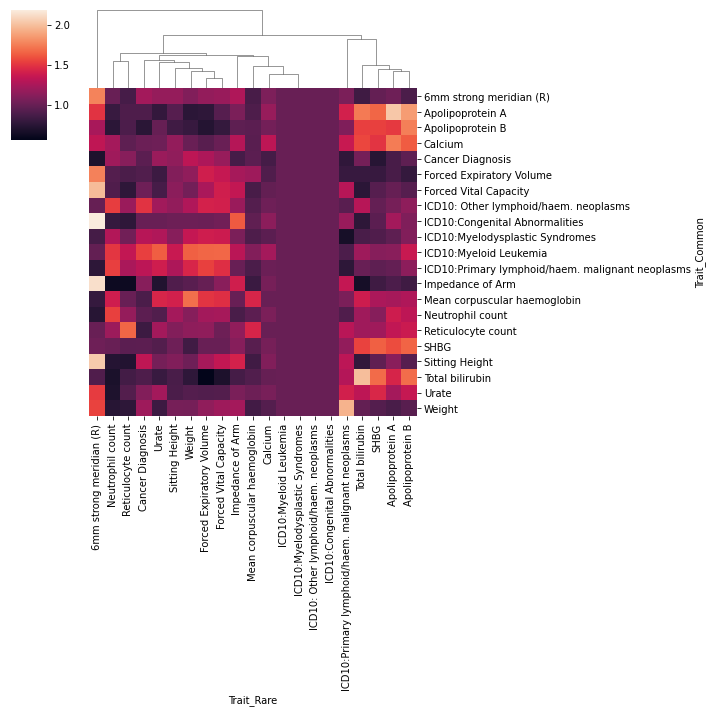

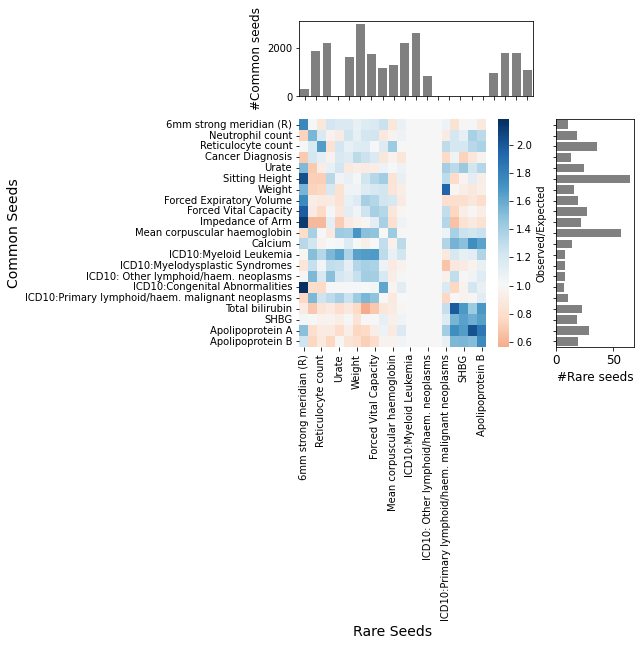

In [270]:
order= plot_heatmap_with_bars(pilot, 'OE', rare_counts, common_counts)

In [285]:
def plot_just_heatmap(heat_data, col_to_plot, rare_count, common_count, order=None, anno=None, 
                      rcol="Trait_Rare", ccol="Trait_Common", cmap="RdBu"):
    
    if anno is not None:
        anno = anno.loc[order, order]
        anno = anno.fillna("")
        
    plot_data = heat_data.pivot(index=ccol, columns=rcol, values=col_to_plot)
    plot_data = plot_data.fillna(1)
    if col_to_plot in ['p_Size', 'p_NPS', 'Overlap_p']:
        plot_data = -1 * np.log10(plot_data)
        vmax = 10
        center= 5
        vmin = 0
    else:
        vmax = np.max(np.max(plot_data))
        vmin = 0
        center=1
    #print(plot_data.head())
    if order is None:
        cg = sns.clustermap(plot_data, row_cluster=False, vmax=vmax)
        order = [plot_data.index[i] for i in cg.dendrogram_col.reordered_ind]
    
    plot_data = plot_data.loc[order, order]
    # plot top bar plot

    # plot heatmap
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    if anno is not None:
        g = sns.heatmap(plot_data, cmap=cmap, center=center, cbar_kws={'label':"Observed/Expected", "location":"right"}, 
                    square=True, vmax=vmax, annot=anno.to_numpy(), fmt='s', ax=ax, vmin=vmin)
    else:
        g = sns.heatmap(plot_data, cmap=cmap, center=center, cbar_kws={'label':"Observed/Expected", "location":"right"}, 
                    square=True, vmax=vmax, ax=ax, vmin=vmin)
    g.set_facecolor("lightgrey")
    #axs[1][0].set_xlabel("Rare Seeds", fontsize=14)
    #axs[1][0].set_ylabel("Common Seeds", fontsize=14)
    #plt.xticks(fontsize=12)
    #plt.yticks(fontsize=12)
    # remove top right

    
    
    
    

In [298]:
order = [  'ICD10:Congenital Abnormalities',
    'ICD10:Myeloid Leukemia',
 'ICD10:Myelodysplastic Syndromes',
 'ICD10: Other lymphoid/haem. neoplasms',
          'ICD10:Primary lymphoid/haem. malignant neoplasms',
 'Cancer Diagnosis',
 'Sitting Height',
 'Weight',
 'Forced Expiratory Volume',
 'Forced Vital Capacity',
 'Impedance of Arm',
    '6mm strong meridian (R)',
'Calcium',
'Mean corpuscular haemoglobin',
'Neutrophil count',
 'Reticulocyte count',
    'Urate',
 'Total bilirubin',
 'SHBG',
 'Apolipoprotein A',
 'Apolipoprotein B'][::-1]

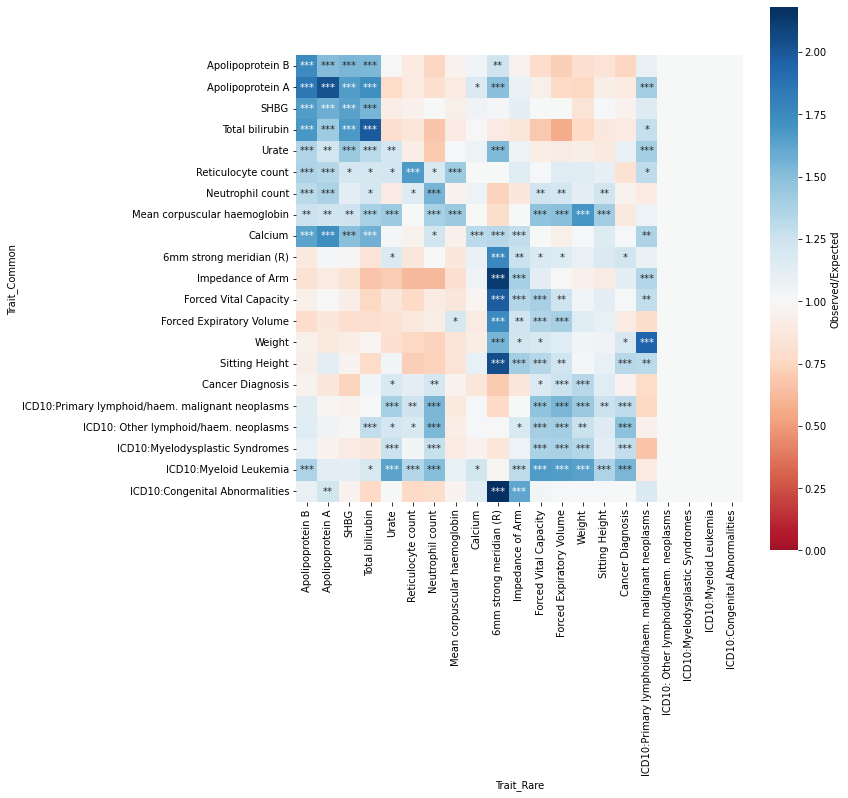

In [299]:
plot_just_heatmap(pilot, 'OE', rare_counts, common_counts, order=order, anno=anno)

In [254]:
overlap[overlap["TraitC"]=="Weight"]

,TraitC,TraitR,Common,Rare,Overlap,Overlap_p
231,Weight,Apolipoprotein A,1014,29,0,0.799589
232,Weight,Apolipoprotein B,1014,19,1,0.273106
233,Weight,SHBG,1014,18,0,0.631158
234,Weight,Total bilirubin,1014,23,0,0.720461
235,Weight,Urate,1014,24,2,0.136556
236,Weight,Impedance of Arm,1014,22,3,0.028189
237,Weight,Mean corpuscular haemoglobin,1014,57,6,0.032680
238,Weight,Neutrophil count,1014,18,3,0.013979
239,Weight,Reticulocyte count,1014,36,3,0.126721
240,Weight,Sitting Height,1014,65,7,0.022961


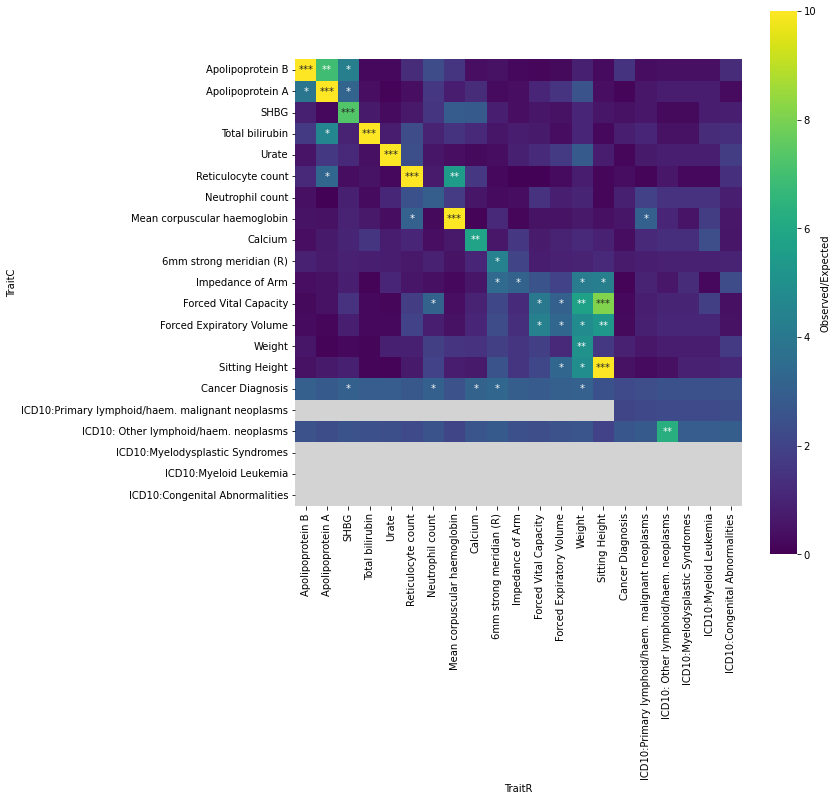

In [302]:
anno2 = overlap.pivot(index="TraitC", columns="TraitR", values="anno")
plot_just_heatmap(overlap, 'Overlap_p', rare_counts, common_counts, order=order, anno=anno2, rcol="TraitR", ccol="TraitC", cmap="viridis")

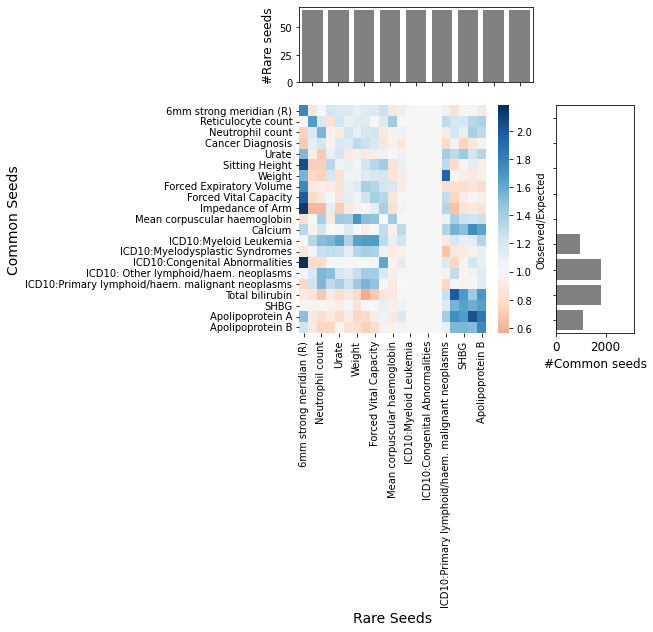

In [83]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), gridspec_kw={"width_ratios":[3,1], "height_ratios":[1,3], "wspace":0.15, "hspace":0.15})
overlap=overlap.loc[order]
a= ratio
a = a.loc[order, order]
#overlap.loc[:, "Common"].plot.barh( ax=axs[1][1])
axs[0][0].bar(x=overlap.index, height=overlap["Rare"], color="grey")
axs[0][0].set_xlim(-0.5, 8.5)
axs[0][0].set_xticklabels([])
axs[0][0].set_ylabel("#Rare seeds", fontsize=12)
overlap=overlap.loc[order[::-1]]
axs[1][1].barh(y=overlap.index, width=overlap["Common"], color="grey")
axs[1][1].set_ylim(-0.5, 8.5)
axs[1][1].set_yticklabels([])
axs[1][1].set_xlabel("#Common seeds", fontsize=12)
#overlap.loc[:, "Rare"].plot.bar( ax=axs[0])
g = sns.heatmap(a, cmap='RdBu', center=1, cbar_kws={'label':"Observed/Expected", "location":"right"}, square=False, ax=axs[1][0])
g.set_facecolor("lightgrey")
axs[1][0].set_xlabel("Rare Seeds", fontsize=14)
axs[1][0].set_ylabel("Common Seeds", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
axs[0][1].axis('off')
plt.savefig("/cellar/users/snwright/Data/Transfer/RVC/pilot_rare_common_bars.png", bbox_inches="tight", dpi=400)


In [ ]:
plot_just

(0.0, 1.0, 0.0, 1.0)

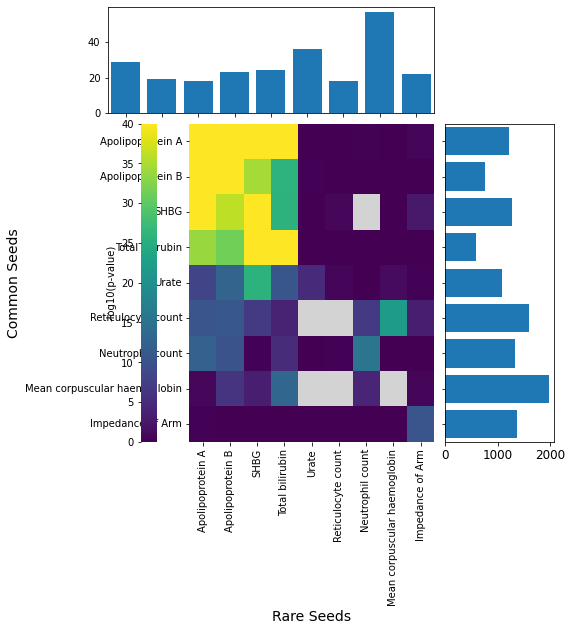

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8), gridspec_kw={"width_ratios":[3,1], "height_ratios":[1,3], "wspace":0.05, "hspace":0.05})
overlap=overlap.loc[order]
a = a.loc[order, order]
#overlap.loc[:, "Common"].plot.barh( ax=axs[1][1])
axs[0][0].bar(x=overlap.index, height=overlap["Rare"])
axs[0][0].set_xlim(-0.5, 8.5)
axs[0][0].set_xticklabels([])
overlap=overlap.loc[order[::-1]]
axs[1][1].barh(y=overlap.index, width=overlap["Common"])
axs[1][1].set_ylim(-0.5, 8.5)
axs[1][1].set_yticklabels([])
#overlap.loc[:, "Rare"].plot.bar( ax=axs[0])
g = sns.heatmap(-1 * np.log10(a), vmax=40, cmap='viridis', cbar_kws={'label':"-log10(p-value)", "location":"left"}, square=False, ax=axs[1][0])
g.set_facecolor("lightgrey")
axs[1][0].set_xlabel("Rare Seeds", fontsize=14)
axs[1][0].set_ylabel("Common Seeds", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
axs[0][1].axis('off')
#plt.savefig("/cellar/users/snwright/Data/Transfer/RVC/pilot_p_size_heatmap.png", bbox_inches="tight", dpi=400)


In [11]:
overlap_mat = pd.read_csv(datadir+"pilot_overlap_results_matrix.txt", sep="\t")
overlap_mat = overlap_mat.replace(traits)

In [12]:
overlap_nums = overlap_mat.pivot("TraitC", "TraitR", "Overlap")
overlap_nums = overlap_nums.loc[order, order]

In [13]:
overlap_p = overlap_mat.pivot("TraitC", "TraitR", "Overlap_p")
overlap_p = overlap_p.loc[order, order]

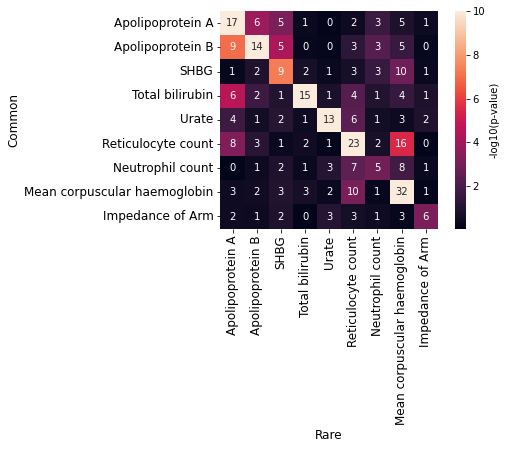

In [165]:
sns.heatmap(-1* np.log10(overlap_p), annot=overlap_nums, vmax =10, cbar_kws={'label':"-log10(p-value)"}, square=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Common", fontsize=12)
plt.xlabel("Rare", fontsize=12)
plt.savefig("/cellar/users/snwright/Data/Transfer/RVC/pilot_hyperOverlap_heatmap.png", bbox_inches = "tight", dpi=400)

In [143]:
ratio_sig = p_size < 0.01

In [144]:
ratio_sig

Trait_Rare,Apolipoprotein A,Apolipoprotein B,SHBG,Total bilirubin,Urate,Reticulocyte count,Neutrophil count,Mean corpuscular haemoglobin,Impedance of Arm
Trait_Common,,,,,,,,,
Apolipoprotein A,True,True,True,True,False,False,False,False,False
Apolipoprotein B,True,True,True,True,False,False,False,False,False
SHBG,True,True,True,True,False,False,False,False,True
Total bilirubin,True,True,True,True,False,False,False,False,False
Urate,True,True,True,True,True,False,False,False,False
Reticulocyte count,True,True,True,True,False,False,True,True,True
Neutrophil count,True,True,False,True,False,False,True,False,False
Mean corpuscular haemoglobin,False,True,True,True,False,False,True,False,False
Impedance of Arm,False,False,False,False,False,False,False,False,True


ValueError: Unknown format code 's' for object of type 'float'

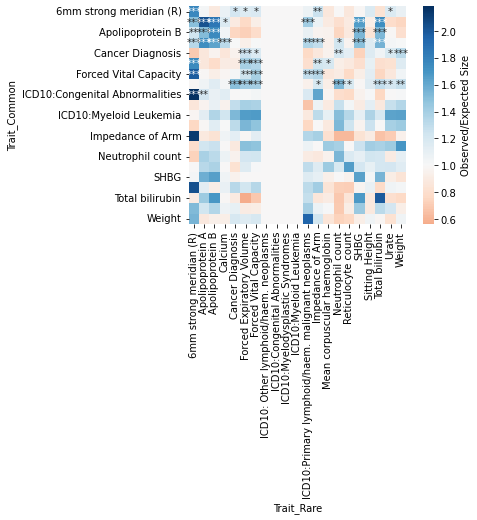

In [198]:
sns.heatmap(ratio,cmap='RdBu', cbar_kws={'label':"Observed/Expected Size"}, square=True, center=1, annot=anno.to_numpy(), fmt='s')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Common", fontsize=12)
plt.xlabel("Rare", fontsize=12)
#plt.savefig("/cellar/users/snwright/Data/Transfer/RVC/pilot_OE_heatmap.png", bbox_inches = "tight", dpi=400)

# Scope of rare variants

## Continuous traits

In [14]:
cont = pd.read_csv(datadir+"AZdata/Table17_pan_quant.txt", sep="\t")

In [15]:
def get_number_of_genes(data, th, phe_col, gene_col, p_col):
    data = data[data[p_col] < th]
    results = data.loc[:, (gene_col, phe_col)].drop_duplicates()
    pheno_counts = results.groupby(phe_col).count()
    gene_th = [i for i in range(1, 50)]
    traits_meeting_th = []
    for x in gene_th:
        traits_meeting_th.append( np.sum(pheno_counts >= x)[0])
    return traits_meeting_th


In [17]:
a = get_number_of_genes(cont, 0.0001, "pheno", "geno", "p")
b = get_number_of_genes(cont, 0.0000001, "pheno", "geno", "p")

test_th = [1e-3, 1e-4,5e-5, 1e-5, 2.5e-6, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

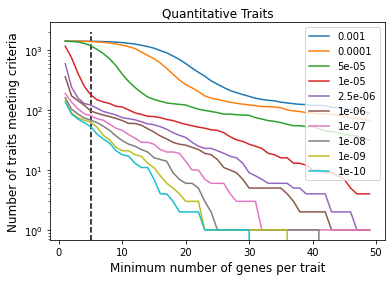

In [18]:
res = pd.DataFrame({t: get_number_of_genes(cont, t, "pheno", "geno", "p") for t in test_th}, index=[i for i in range(1, 50)])
res.plot()
plt.yscale("log")
plt.vlines(5, 0, 2000, linestyle="dashed", color="black")
plt.xlabel("Minimum number of genes per trait", fontsize=12)
plt.ylabel("Number of traits meeting criteria", fontsize=12)
plt.title("Quantitative Traits")
plt.savefig("/cellar/users/snwright/Data/Transfer/RVC/quant_trait_count.png", bbox_inches="tight", dpi=400)

In [22]:
{t: get_number_of_genes(cont, t, "pheno", "geno", "p") for t in test_th}[2.5e-6]

[598,
 241,
 159,
 129,
 122,
 108,
 95,
 89,
 83,
 75,
 72,
 69,
 64,
 59,
 57,
 53,
 48,
 42,
 38,
 35,
 29,
 25,
 23,
 23,
 21,
 19,
 17,
 16,
 13,
 9,
 8,
 7,
 6,
 6,
 6,
 6,
 5,
 5,
 4,
 4,
 4,
 4,
 2,
 2,
 2,
 2,
 1,
 1,
 1]

In [179]:
np.sum(get_number_of_genes(cont, 0.00001, "pheno", "geno") > 50)

geno    3
dtype: int64

In [175]:
cont.head()

,geno,pheno,phenotype_dedup,Root,nSamples,nCases,nControls,p,beta,lower,upper,se,MedCases,MedControls,beta_eur,p.eur,model
0,CST3,30720,Cystatin C,Chapter III Diseases of the blood and blood-fo...,267750,118,267632,0.0,-3.354652,-3.516812,-3.192492,0.082736,-3.366538,0.000505,-3.375316,0.0,ptv
1,GPT,30620,Alanine aminotransferase,Chapter XI Diseases of the digestive system,267664,1842,265822,0.0,-1.319492,-1.362261,-1.276724,0.021821,-1.446579,0.005998,-1.317500,0.0,flexdmg
2,ALPL,30610,Alkaline phosphatase,Chapter XI Diseases of the digestive system,267769,2599,265170,0.0,-1.557665,-1.595021,-1.520308,0.019060,-1.757323,0.008825,-1.563213,0.0,flexdmg
3,CST3,30720,Cystatin C,Chapter III Diseases of the blood and blood-fo...,267750,222,267528,0.0,-2.408228,-2.526486,-2.289970,0.060337,-3.121020,0.000786,-2.432802,0.0,flexdmg
4,GOT1,30650,Aspartate aminotransferase,Chapter XI Diseases of the digestive system,266807,829,265978,0.0,-1.532285,-1.597299,-1.467272,0.033171,-1.727133,0.002586,-1.562553,0.0,flexdmg


# Binary traits

In [19]:
binary = pd.read_csv(datadir+"AZdata/Table16_pan_binary.txt", sep="\t")

In [203]:
binary.head()

,phenotype,genotype,EUR_pValue,AFR_pValue,EAS_pValue,SAS_pValue,cmh_pValue,cmh_odds_ratio,cmh_lci,cmh_uci,...,AFR_CaseQ,SAS_CtrlNQ,SAS_CtrlQ,SAS_CaseNQ,SAS_CaseQ,EAS_CtrlNQ,EAS_CtrlQ,EAS_CaseNQ,EAS_CaseQ,model
0,Union#D56#D56 Thalassaemia,HBB,7.610000e-93,1.0,0.1184,2.740000e-46,3.480000e-118,1186.281200,656.422534,2451.144895,...,0.0,4436.0,10.0,83.0,33.0,1445.0,7.0,22.0,1.0,ptv5pcnt
1,Source of report of D56 (thalassaemia),HBB,3.060000e-91,1.0,0.1110,4.350000e-42,6.660000e-112,1225.044263,655.130468,2474.924471,...,0.0,3437.0,11.0,74.0,32.0,1346.0,7.0,19.0,1.0,ptv5pcnt
2,20002#1427#polycystic kidney,PKD1,1.230000e-103,NaN,NaN,3.600000e-03,1.920000e-105,1641.099178,1050.256410,2915.302491,...,NaN,5551.0,3.0,4.0,1.0,NaN,NaN,NaN,NaN,ptv
3,20002#1427#polycystic kidney,PKD1,1.230000e-103,NaN,NaN,3.600000e-03,1.920000e-105,1641.099178,1050.256410,2915.302491,...,NaN,5551.0,3.0,4.0,1.0,NaN,NaN,NaN,NaN,ptv5pcnt
4,Source of report of Q61 (cystic kidney disease),PKD1,4.660000e-98,1.0,NaN,8.600000e-03,2.040000e-99,660.679392,410.647378,1077.061609,...,0.0,5569.0,3.0,11.0,1.0,NaN,NaN,NaN,NaN,ptv


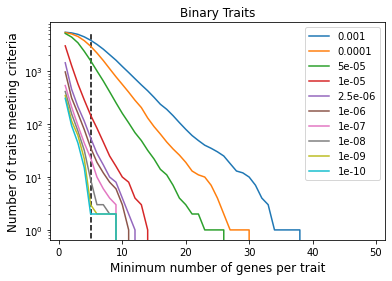

In [20]:
res = pd.DataFrame({t: get_number_of_genes(binary, t, "phenotype", "genotype", "EUR_pValue") for t in test_th}, index=[i for i in range(1, 50)])
res.plot()
plt.yscale("log")
plt.vlines(5, 0, 5000, linestyle="dashed", color="black")
plt.xlabel("Minimum number of genes per trait", fontsize=12)
plt.ylabel("Number of traits meeting criteria", fontsize=12)
plt.title("Binary Traits")
plt.savefig("/cellar/users/snwright/Data/Transfer/RVC/binary_trait_count.png", bbox_inches="tight", dpi=400)

In [23]:
{t: get_number_of_genes(binary, t, "phenotype", "genotype", "EUR_pValue") for t in test_th}[2.5e-6]

[1448,
 458,
 214,
 114,
 55,
 28,
 17,
 10,
 8,
 4,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [220]:
from scipy.stats import hypergeom

In [227]:
hypergeom(100, 50, 10).sf(0)

0.9994065803274137